In [1]:
#Importación de librearías necesarias
import pandas as pd
from datetime import datetime
import socket
import numpy as np
import math
import time
import pickle  #Para guardar archivos
import os

from pympler import asizeof #Para liberar memoria
import gc

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgb


from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist

In [2]:
#Path general de archivos
if socket.gethostname()=='LAPTOP-PUSGG08B': #Ip de la laptop
    ruta = "E:/Cristian Guatemal/Master/Big Data y Ciencia de Datos/VIU_TFM/Data/TFM/"
    r_ruta = "E:/Cristian Guatemal/Master/Big Data y Ciencia de Datos/VIU_TFM/RData/TFM/"
elif socket.gethostname()=='PCUIOMTDAIE6382': #Ip del working
    ruta =   "D:/Master/Big_Data_Ciencia_Datos/VIU_TFM/Data/TFM/"
    r_ruta = "D:/Master/Big_Data_Ciencia_Datos/VIU_TFM/RData/TFM/"
# Ruta del archivo de pensionistas de vejez
ruta_vj = ruta + 'POB_VEJ_CD656_NEW.dsv'
# Ruta del archivo de historia laboral de pensionistas
ruta_afi = ruta + 'APORTES_CD656_new.dsv'

In [3]:
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_clean_afi_sel_g_all_2.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open( ruta_archivo, 'rb') as archivo:
    data_l = pickle.load( archivo )   

In [4]:
data_l.shape #(62130167, 16)

(62130167, 16)

In [5]:
inicio = time.time()
data_l = data_l.sort_values( by=["CEDULA_COD","ANIO", "MES"], ascending=[ True, True, True] )
data_l.reset_index(inplace=True)
data_l.rename(columns={'index': 'nuevo_indice'}, inplace=True)
data_l.drop(columns=['nuevo_indice'], inplace=True)
data_l['INDICE'] = data_l.index
data_l['ATI_CJ'] = np.nan

#Casos de no análisis
data_no_grupo = data_l[ (data_l['GRUPO_SEL']==0) ].copy()
data_no_grupo['ATI_CJ'] = np.nan

#Casos de análisis
data = data_l[ (data_l['GRUPO_SEL']==1) ].copy()

fin = time.time()  

tm = fin-inicio
print('Tiempo de ejecución es:',tm//3600,' horas con',tm%3600//60,'minutos y',tm%60, 'segundos' )

Tiempo de ejecución es: 0.0  horas con 1.0  minutos y 4.72900915145874  segundos


In [49]:
#Se calculo los bigotes superiores para toda la historia laboral
inicio = time.time() 
dataa = data_l.copy()
dic_aux = dataa.groupby('CEDULA_COD').agg({'SALARIO_SECTOR': list, 'INDICE': list}).to_dict(orient='index')

for cedula in dic_aux:
    dic_aux[cedula]['SALARIO_SECTOR'] = [ [float(val) for val in sal.replace(':', ';').split(';')] 
                                            if isinstance(sal, str) 
                                            else [float(sal)]
                                            for sal in dic_aux[cedula]['SALARIO_SECTOR']
                                        ]
    # Aplanar la lista de listas de SALARIO_SECTOR
    salarios = None
    salarios = [salario for sublist in dic_aux[cedula]['SALARIO_SECTOR'] for salario in sublist]
    dic_aux[cedula]['SAL_PROM1'] =  np.nanmean(salarios)
    dic_aux[cedula]['Q1'] =  np.percentile(salarios, 25)
    dic_aux[cedula]['Q3'] =  np.percentile(salarios, 75)
    dic_aux[cedula]['IQR'] = dic_aux[cedula]['Q3'] -  dic_aux[cedula]['Q1']
    dic_aux[cedula]['LI'] =  dic_aux[cedula]['Q1'] -  1.5  * dic_aux[cedula]['IQR']
    dic_aux[cedula]['LS'] =  dic_aux[cedula]['Q3'] +  1.5  * dic_aux[cedula]['IQR']

data1 = { 'CEDULA_COD': [], 'LS': [], 'SAL_PROM1': [] }

for cedula, val in dic_aux.items():
    data1['CEDULA_COD'].append(cedula)
    data1['LS'].append( val['LS'] )
    data1['SAL_PROM1'].append( val['SAL_PROM1'] )

LS = pd.DataFrame( data1 )
LS = LS.groupby('CEDULA_COD')['LS'].first()
data_l.loc[:, 'LS1'] = data_l['CEDULA_COD'].map(LS)

SPROM = pd.DataFrame( data1 )
SPROM = SPROM.groupby('CEDULA_COD')['SAL_PROM1'].first()
data_l.loc[:, 'SAL_PROM1'] = data_l['CEDULA_COD'].map(SPROM)

del dataa, data1, dic_aux, LS, salarios, SPROM
gc.collect()

##Se calculo los bigotes superiores para toda la historia laboral, a partir del año 2000 en adelante.
dataa = data_l[data_l['ANIO']>=2000].copy()
dic_aux = dataa.groupby('CEDULA_COD').agg({'SALARIO_SECTOR': list, 'INDICE': list}).to_dict(orient='index')

for cedula in dic_aux:
    dic_aux[cedula]['SALARIO_SECTOR'] = [ [float(val) for val in sal.replace(':', ';').split(';')] 
                                            if isinstance(sal, str) 
                                            else [float(sal)]
                                            for sal in dic_aux[cedula]['SALARIO_SECTOR']
                                        ]
    # Aplanar la lista de listas de SALARIO_SECTOR
    salarios = None
    salarios = [salario for sublist in dic_aux[cedula]['SALARIO_SECTOR'] for salario in sublist]
    dic_aux[cedula]['SAL_PROM2'] =  np.nanmean(salarios)
    dic_aux[cedula]['Q1'] =  np.percentile(salarios, 25)
    dic_aux[cedula]['Q3'] =  np.percentile(salarios, 75)
    dic_aux[cedula]['IQR'] = dic_aux[cedula]['Q3'] -  dic_aux[cedula]['Q1']
    dic_aux[cedula]['LI'] =  dic_aux[cedula]['Q1'] -  1.5  * dic_aux[cedula]['IQR']
    dic_aux[cedula]['LS'] =  dic_aux[cedula]['Q3'] +  1.5  * dic_aux[cedula]['IQR']

data1 = { 'CEDULA_COD': [], 'LS': [], 'SAL_PROM2': []  }

for cedula, val in dic_aux.items():
    data1['CEDULA_COD'].append(cedula)
    data1['LS'].append( val['LS'] )
    data1['SAL_PROM2'].append( val['SAL_PROM2'] )

LS = pd.DataFrame( data1 )
LS = LS.groupby('CEDULA_COD')['LS'].first()
data_l.loc[:, 'LS2'] = data_l['CEDULA_COD'].map(LS)

SPROM = pd.DataFrame( data1 )
SPROM = SPROM.groupby('CEDULA_COD')['SAL_PROM2'].first()
data_l.loc[:, 'SAL_PROM2'] = data_l['CEDULA_COD'].map(SPROM)

del dataa, data1, dic_aux, LS, salarios, SPROM
gc.collect()

fin = time.time()  
tm = fin - inicio
print('\tTiempo de ejecución es:',tm//3600,'horas con',tm%3600//60,'minutos y',tm%60,'segundos')

KeyboardInterrupt: 

In [11]:
data_l #cedulas unicas 442570

,CEDULA_COD,ANIO,MES,SALARIO,SALARIO_SECTOR,SECTOR_A,NUM_SEC_MES,%_NUM_SECTOR,GRUPO,SAL_PROM_GRUPO,...,FIN_CAL,BASE_CAL,SBU,ID_SBU,INDICE,ATI_CJ,LS1,SAL_PROM1,LS2,SAL_PROM2
0,126,2004,12,147.45,147.45,PRI,1,1,7,147.450000,...,2006-01-01,210.635,136.0,-1,0,NaN,382.4950,201.720411,382.4950,201.720411
1,126,2005,1,161.67,161.67,PRI,1,1,6,161.670000,...,2006-01-01,210.635,150.0,-1,1,NaN,382.4950,201.720411,382.4950,201.720411
2,126,2005,2,161.67,161.67,PRI,1,1,6,161.670000,...,2006-01-01,210.635,150.0,-1,2,NaN,382.4950,201.720411,382.4950,201.720411
3,126,2005,3,161.67,161.67,PRI,1,1,6,161.670000,...,2006-01-01,210.635,150.0,-1,3,NaN,382.4950,201.720411,382.4950,201.720411
4,126,2005,4,161.67,161.67,PRI,1,1,6,161.670000,...,2006-01-01,210.635,150.0,-1,4,NaN,382.4950,201.720411,382.4950,201.720411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62130162,23594465,2017,11,14045.72,14045.72,PRI,1,1,1,16205.699167,...,2013-04-01,16604.299,375.0,-1,62130162,NaN,17232.8625,15759.244225,17232.8625,15759.244225
62130163,23594465,2017,12,14164.25,14164.25,PRI,1,1,1,16205.699167,...,2013-04-01,16604.299,375.0,-1,62130163,NaN,17232.8625,15759.244225,17232.8625,15759.244225
62130164,23594465,2018,1,12903.21,12903.21,PRI,1,1,1,16205.699167,...,2013-04-01,16604.299,386.0,-1,62130164,NaN,17232.8625,15759.244225,17232.8625,15759.244225
62130165,23594465,2018,2,42432.21,42432.21,PRI,1,1,1,16205.699167,...,2013-04-01,16604.299,386.0,-1,62130165,NaN,17232.8625,15759.244225,17232.8625,15759.244225


In [13]:
data['CEDULA_COD'].nunique() # cedulas unicas 442570

442570

In [14]:
#Algortimos Cluster jerarquico
inicio = time.time() 

cedula_1 = data.groupby('CEDULA_COD')['NUM_SEC_MES'].apply( lambda x: (x != 1).any() )
cedula_dist = cedula_1[ cedula_1 ].index
ul = data[ ~data['CEDULA_COD'].isin( cedula_dist )]
ml = data[  data['CEDULA_COD'].isin( cedula_dist )]

fin = time.time()  
tm = fin - inicio
print('\tTiempo de ejecución es:',tm//3600,'horas con',tm%3600//60,'minutos y',tm%60,'segundos')

del data

	Tiempo de ejecución es: 0.0 horas con 0.0 minutos y 54.60968279838562 segundos


In [15]:
print('Número de cédulas en ul', ul['CEDULA_COD'].nunique()) #cedulas unicas 373069
print('Número de cédulas en ml', ml['CEDULA_COD'].nunique()) #cedulas unicas 69501

Número de cédulas en ul 373069
Número de cédulas en ml 69501


In [17]:
#Se calculo los bigotes superiores para la historia laboral de los mejores años
inicio = time.time() 
dataa = ul.copy()
dic_aux = dataa.groupby('CEDULA_COD').agg({'SALARIO_SECTOR': list, 'INDICE': list}).to_dict(orient='index')

for cedula in dic_aux:
    dic_aux[cedula]['SALARIO_SECTOR'] = [ [float(val) for val in sal.replace(':', ';').split(';')] 
                                            if isinstance(sal, str) 
                                            else [float(sal)]
                                            for sal in dic_aux[cedula]['SALARIO_SECTOR']
                                        ]
    # Aplanar la lista de listas de SALARIO_SECTOR
    salarios = None
    salarios = [salario for sublist in dic_aux[cedula]['SALARIO_SECTOR'] for salario in sublist]
    dic_aux[cedula]['Q1'] =  np.percentile(salarios, 25)
    dic_aux[cedula]['Q3'] =  np.percentile(salarios, 75)
    dic_aux[cedula]['IQR'] = dic_aux[cedula]['Q3'] -  dic_aux[cedula]['Q1']
    dic_aux[cedula]['LI'] =  dic_aux[cedula]['Q1'] -  1.5  * dic_aux[cedula]['IQR']
    dic_aux[cedula]['LS'] =  dic_aux[cedula]['Q3'] +  1.5  * dic_aux[cedula]['IQR']

data1 = { 'CEDULA_COD': [], 'LS': []}

for cedula, val in dic_aux.items():
    data1['CEDULA_COD'].append(cedula)
    data1['LS'].append( val['LS'] )

LS = pd.DataFrame( data1 )
LS = LS.groupby('CEDULA_COD')['LS'].first()
data_l.loc[ ~data_l['CEDULA_COD'].isin( cedula_dist ), 'LS_MS'] = data_l['CEDULA_COD'].map(LS)

del dataa, data1, dic_aux, LS
gc.collect()

dataa = ml.copy()
dic_aux = dataa.groupby('CEDULA_COD').agg({'SALARIO_SECTOR': list, 'INDICE': list}).to_dict(orient='index')

for cedula in dic_aux:
    dic_aux[cedula]['SALARIO_SECTOR'] = [ [float(val) for val in sal.replace(':', ';').split(';')] 
                                            if isinstance(sal, str) 
                                            else [float(sal)]
                                            for sal in dic_aux[cedula]['SALARIO_SECTOR']
                                        ]
    # Aplanar la lista de listas de SALARIO_SECTOR
    salarios = None
    salarios = [salario for sublist in dic_aux[cedula]['SALARIO_SECTOR'] for salario in sublist]
    dic_aux[cedula]['Q1'] =  np.percentile(salarios, 25)
    dic_aux[cedula]['Q3'] =  np.percentile(salarios, 75)
    dic_aux[cedula]['IQR'] = dic_aux[cedula]['Q3'] -  dic_aux[cedula]['Q1']
    dic_aux[cedula]['LI'] =  dic_aux[cedula]['Q1'] -  1.5  * dic_aux[cedula]['IQR']
    dic_aux[cedula]['LS'] =  dic_aux[cedula]['Q3'] +  1.5  * dic_aux[cedula]['IQR']

data1 = { 'CEDULA_COD': [], 'LS': []}

for cedula, val in dic_aux.items():
    data1['CEDULA_COD'].append(cedula)
    data1['LS'].append( val['LS'] )

LS = pd.DataFrame( data1 )
LS = LS.groupby('CEDULA_COD')['LS'].first()
data_l.loc[  data_l['CEDULA_COD'].isin( cedula_dist ), 'LS_MS'] = data_l['CEDULA_COD'].map(LS)

fin = time.time()  
tm = fin - inicio
print('\tTiempo de ejecución es:',tm//3600,'horas con',tm%3600//60,'minutos y',tm%60,'segundos')

del dataa, data1, dic_aux, LS
gc.collect()

0

In [37]:
# data_l[ (~data_l['CEDULA_COD'].isin( cedula_dist )) & (data_l['LS_MS'].isna()) ]
data_l[data_l['CEDULA_COD']==216]

,CEDULA_COD,ANIO,MES,SALARIO,SALARIO_SECTOR,SECTOR_A,NUM_SEC_MES,%_NUM_SECTOR,GRUPO,SAL_PROM_GRUPO,...,BASE_CAL,SBU,ID_SBU,INDICE,ATI_CJ,LS1,SAL_PROM1,LS2,SAL_PROM2,LS_MS
136,216,2004,7,282.95,282.95,PUB,1,1,6,339.176667,...,566.339833,136.0,-1,136,NaN,793.735,357.121633,793.735,357.121633,884.2975
137,216,2004,8,282.95,282.95,PUB,1,1,6,339.176667,...,566.339833,136.0,-1,137,NaN,793.735,357.121633,793.735,357.121633,884.2975
138,216,2004,9,451.63,282.95;168.68,PUB;PRI,2,0.6265;0.3735,6,339.176667,...,566.339833,136.0,-1,138,NaN,793.735,357.121633,793.735,357.121633,884.2975
139,216,2004,10,451.63,282.95;168.68,PUB;PRI,2,0.6265;0.3735,5,494.748333,...,566.339833,136.0,-1,139,NaN,793.735,357.121633,793.735,357.121633,884.2975
140,216,2004,11,451.63,168.68;282.95,PRI;PUB,2,0.3735;0.6265,5,494.748333,...,566.339833,136.0,-1,140,NaN,793.735,357.121633,793.735,357.121633,884.2975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,216,2009,5,641.34,641.34,PUB,1,1,1,625.315000,...,566.339833,218.0,-1,194,NaN,793.735,357.121633,793.735,357.121633,884.2975
195,216,2009,6,641.34,641.34,PUB,1,1,1,625.315000,...,566.339833,218.0,-1,195,NaN,793.735,357.121633,793.735,357.121633,884.2975
196,216,2009,7,641.34,641.34,PUB,1,1,1,625.315000,...,566.339833,218.0,-1,196,NaN,793.735,357.121633,793.735,357.121633,884.2975
197,216,2009,8,641.34,641.34,PUB,1,1,1,625.315000,...,566.339833,218.0,-1,197,NaN,793.735,357.121633,793.735,357.121633,884.2975


In [38]:
#Verificación de valores LS calculados
a = [ [float(val) for val in sal.replace(':', ';').split(';')] 
                                        if isinstance(sal, str) 
                                        else [float(sal)]
                                        for sal in data_l[ (data_l['CEDULA_COD']==216)]['SALARIO_SECTOR']
                                    ]
# Aplanar la lista de listas de SALARIO_SECTOR
salarios = None
salarios = [salario for sublist in a for salario in sublist]
salarios
print('sal promedio', np.nanmean(salarios))
q1=  np.percentile(salarios, 25)
q3 =  np.percentile(salarios, 75)
iqr = q3 -  q1
print('Ls', q3+1.5*iqr)

b = [ [float(val) for val in sal.replace(':', ';').split(';')] 
                                        if isinstance(sal, str) 
                                        else [float(sal)]
                                        for sal in ml[ (ml['CEDULA_COD']==216) ]['SALARIO_SECTOR']
                                    ]
salarios = None
salarios = [salario for sublist in b for salario in sublist]
salarios
print('sal promedio', np.nanmean(salarios))
q1=  np.percentile(salarios, 25)
q3 =  np.percentile(salarios, 75)
iqr = q3 -  q1
print('LS_MS', q3+1.5*iqr)


sal promedio 357.1216326530611
Ls 793.735
sal promedio 361.4935106382979
LS_MS 884.2975


In [50]:
#Para ejecutar el cluster jerarquico
def cluster_jerarquico( data_si_dic ):
    print('Algoritmo Cluster Jerárquico')
    inicio = time.time()
    nom = 'ATI_CJ'
    data_val_ati = {}
    for cedula in data_si_dic:

        if( len( data_si_dic[ cedula ]['SALARIO'] ) > 1 ): #Para formar al menos un cluster

            aux = np.array( data_si_dic[ cedula ]['SALARIO'] ).reshape(-1, 1)
            Z = linkage( aux , method='single', metric='euclidean')

            num_clusters = 2  # Puedes ajustar este valor según tus necesidades
            clusters = fcluster(Z, num_clusters, criterion='maxclust')

            if( len( np.unique(clusters) ) > 1 ): #Para considerar al menos 2 cluster
                # Calcular el centroide de cada clúster
                cluster_centers = np.array([[ np.nanmean(aux[clusters == i], axis=0)[0], i ] for i in range(1, num_clusters + 1)] ) 

                Q1 = np.quantile(aux, 0.25)
                Q3 = np.quantile(aux, 0.75)
                IQR = Q3-Q1
                LI = Q1 - 1.5 * IQR
                LS = Q3 + 1.5 * IQR

                cl_at = np.where( cluster_centers[:,0] > (LS +  1e-8) )[0]
                cluster_centers[cl_at][:, 1]

                mod_aux = np.zeros((len(aux), 2))
                mod_aux[:, 0] = aux[:, 0]  # Copiar los valores originales de aux en la primera columna
                mod_aux[np.isin(clusters, cluster_centers[cl_at][:, 1]), 1] = 1  # Asignar 1 en la segunda columna donde el cluster es 1

                data_val_ati[cedula] = {'SALARIO': mod_aux[:, 0].tolist(),
                                             nom : mod_aux[:, 1].tolist(),
                                        'INDICE' : data_si_dic[ cedula ]['INDICE']}
            else:
                data_val_ati[cedula] = { 'SALARIO': aux.flatten().tolist(),
                                               nom:  [-1] * len(aux),
                                         'INDICE' : data_si_dic[ cedula ]['INDICE']} 

        else:
            data_val_ati[cedula] = { 'SALARIO': data_si_dic[ cedula ]['SALARIO'],
                                           nom:  [-2] * len( data_si_dic[ cedula ]['SALARIO'] ),
                                     'INDICE' : data_si_dic[ cedula ]['INDICE']}
    fin = time.time()  
    tm = fin-inicio
    print('\tTiempo de ejecución es:',tm//3600,'horas con',tm%3600//60,'minutos y',tm%60,'segundos' )
    
    return data_val_ati
 
#Para unir los resultados
def extend_data( data_val_ati ):
    print('Extensión del diccionario')
    inicio = time.time()
    nom = 'ATI_CJ'
    data1 = { 'CEDULA_COD': [], 'SALARIO': [], nom : [], 'INDICE':[]}

    # Llenar las listas con los datos del diccionario
    for cedula, values in data_val_ati.items():
        salario = values['SALARIO']
        atipico = values[ nom ]
        indice = values['INDICE']
        num_rows = len(salario)

        # Extender las listas en el diccionario de datos
        data1['CEDULA_COD'].extend([cedula] * num_rows)
        data1['SALARIO'].extend(salario)
        data1[ nom ].extend(atipico)
        data1['INDICE'].extend(indice)

    fin = time.time()  
    tm=fin-inicio
    print('\tTiempo de ejecución es: ',  tm//3600, ' horas con ' ,  tm%3600//60 , ' minutos y',  tm%60, ' segundos' )
    return data1

#Para graficar el comportamiento de los atipicos
def graf_CJ(data_i, ced, val, grupo_sel = 0):
    #Adecuación de la base de datos
    idx = data_i.columns.get_loc('ATI_CJ')
    columnas_requeridas = ['CEDULA_COD', 'ANIO', 'MES', val, 'GRUPO_SEL', 'INDICE', 'BASE_CAL'] + list(data_i.columns[idx:])
    data = data_i[data_i['CEDULA_COD'] == ced][columnas_requeridas]
    
    # Establecer si se quieren todos o solos los 5 mejores años
    if(grupo_sel == 1):
        data = data[data['GRUPO_SEL']==1]
    
    #Fecha para eje x
    anios = data['ANIO'].tolist()
    meses = data['MES'].tolist()
    fechas = [datetime(year=anio, month=mes, day=1) for anio, mes in zip(anios, meses)]
    data['FECHA']= pd.to_datetime(fechas)
    data = data.sort_values(by='FECHA')
    
    #Paleta de colores
    colors = plt.get_cmap('tab20').colors

    # Gráfico
    plt.figure(figsize=(12, 8))  
    marker_dict = {1: 'o', 2: 'x'} 
    
    data_aux = data[data['GRUPO_SEL']==1]
    if grupo_sel == 0: 
        Grupo_b= data[(data['GRUPO_SEL'] == 0)]
        plt.scatter(Grupo_b['FECHA'], Grupo_b[val], marker= '^', color='yellow', label='Valores no considerados')
        
        if 0 in (data_aux['ATI_CJ'].unique()):
            Grupo_a = data_aux[data_aux['ATI_CJ'] == 0]
            plt.scatter(Grupo_a['FECHA'], Grupo_a[val], marker= marker_dict[1], color='blue', label='Valores No Atípicos : 0')

        if 1 in (data_aux['ATI_CJ'].unique()):
            Grupo= data_aux[data_aux['ATI_CJ'] == 1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'red', label='Valores Atípicos : 1')
            
        if -1 in (data_aux['ATI_CJ'].unique()):
            Grupo= data_aux[data_aux['ATI_CJ'] == -1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'green', label='Clúster único')
                
    else:
        if 0 in (data['ATI_CJ'].unique()):
            Grupo_a = data[data['ATI_CJ'] == 0]
            plt.scatter(Grupo_a['FECHA'], Grupo_a[val], marker= marker_dict[1], color='blue', label='Valores No Atípicos : 0')

        if 1 in (data['ATI_CJ'].unique()):
            Grupo= data[data['ATI_CJ'] == 1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'red', label='Valores Atípicos : 1')
            
        if -1 in (data['ATI_CJ'].unique()):
            Grupo= data[data['ATI_CJ'] == -1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'green', label='Clúster único')
        
    
    plt.axhline(y= data['SAL_PROM2'].iloc[0], color= '#1297ff', linestyle='-', label='Promedio Salarios')
    plt.axhline(y=data['LS2'].iloc[0], alpha=1 , color= '#25ce00', linestyle='--', label='LS2')
    plt.axhline(y=data_aux['LS_MS'].iloc[0], alpha=1, color= '#875b20', linestyle='--', label='LS_MS')
    plt.axhline(y=data['BASE_CAL'].iloc[0], alpha=1, color= '#E800FF', linestyle=':', label='Base de cálculo')
    
    # Añadir el número de clusters, EPS, MINPTS
    plt.scatter( data_aux['FECHA'].iloc[0], data_aux[val].iloc[0], facecolors='none', label="Número de clústers: {}".format(int(max(data_aux['ATI_CJ'].unique()) + 1)))
    
    # Añadir títulos y etiquetas
    plt.title(f"Aportaciones de la cédula: {ced}")
    plt.xlabel('FECHA')
    plt.ylabel(f"{val}")
    
    # Crear la leyenda
    leyenda = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    
    plt.grid(True)
    plt.show()

In [40]:
print('Tamaño de la data utilizada con un único sector dentro de los mejores años de sueldo', ul.shape) #(26006294, 16)
print('Tamaño de la data utilizada con múltiples sectores dentro de los mejores años de sueldo', ml.shape) #(26006294, 16)
print('Convertir el dataframe a diccionario')
inicio = time.time()

ul_dic = ul.groupby('CEDULA_COD').agg({'SALARIO': list, 'INDICE': list}).to_dict(orient='index')
ml_dic = ml.groupby('CEDULA_COD').agg({'SALARIO': list, 'INDICE': list}).to_dict(orient='index')

fin = time.time()  
tm = fin-inicio
print('\tTiempo de ejecución es:',tm//3600,'horas con',tm%3600//60,'minutos y',tm%60,'segundos' )

data_val_ati1 = cluster_jerarquico( ul_dic)
data_val_ati2 = cluster_jerarquico( ml_dic)

data1 = extend_data( data_val_ati1 )
data2 = extend_data( data_val_ati2 )


print('Concatenación de dataframe')
inicio = time.time()
nom = 'ATI_CJ'
data_jerar = None
data_jerar = pd.concat( [ data_no_grupo[['CEDULA_COD', 'SALARIO',  nom , 'INDICE']],
                          pd.DataFrame( data1 ), pd.DataFrame( data2 ) ], axis=0)

data_jerar = data_jerar.sort_values( by=["INDICE"], ascending=[ True ] )
data_jerar.reset_index(inplace=True)
data_jerar.rename(columns={'index': 'nuevo_indice'}, inplace=True)
data_jerar.drop(columns=['nuevo_indice'], inplace=True)

col = ['ATI_CJ']

for nom_col in col:
    aux = None
    aux = data_jerar[ nom_col ].to_numpy()
    data_l.iloc[:, data_l.columns.get_loc( nom_col )] = aux

del data1, data2, data_val_ati1, data_val_ati2, ul_dic, ml_dic, data_jerar, aux
gc.collect()
    
fin = time.time()  
tm = fin-inicio
print('\tTiempo de ejecución es:',tm//3600,'horas con',tm%3600//60 ,'minutos y',tm%60,'segundos' )

Tamaño de la data utilizada con un único sector dentro de los mejores años de sueldo (22324287, 18)
Tamaño de la data utilizada con múltiples sectores dentro de los mejores años de sueldo (4147829, 18)
Convertir el dataframe a diccionario
	Tiempo de ejecución es:  0.0  horas con  0.0  minutos y 23.259310722351074  segundos
Algoritmo Cluster Jerárquico
	Tiempo de ejecución es: 0.0 horas con 3.0  minutos y 9.506385564804077  segundos
Algoritmo Cluster Jerárquico
	Tiempo de ejecución es: 0.0 horas con 0.0  minutos y 36.47765135765076  segundos
Extensión del diccionario
	Tiempo de ejecución es:  0.0  horas con  0.0  minutos y 1.636946439743042  segundos
Extensión del diccionario
	Tiempo de ejecución es:  0.0  horas con  0.0  minutos y 0.32140135765075684  segundos
Concatenación de dataframe
	Tiempo de ejecución es:  0.0  horas con  0.0  minutos y 29.728490352630615  segundos


In [42]:
#El valor de -1 implica que se formó un solo cluster
#El valor de -2 implica que en la selección de datos, la cedula solo tenía un único valor para formar los cluster
# pues era el resultado de filtrar el data_si

#Se analiza el caso de los valores de atipicos del método 1
data_l[ ( data_l['GRUPO_SEL']==1 )]['ATI_CJ'].unique() #array([ 0.,  1., -1.])
data_l['ATI_CJ'].unique() #array([nan,  0.,  1., -1.])

array([nan,  0.,  1., -1.])

In [45]:
data_l[ (data_l['CEDULA_COD'].isin( cedula_dist )) & (data_l['GRUPO_SEL']==1)]['ATI_CJ'].unique()  #array([ 0.,  1., -1.])
data_l[ (~data_l['CEDULA_COD'].isin( cedula_dist )) & (data_l['GRUPO_SEL']==1)]['ATI_CJ'].unique() #array([ 0.,  1., -1.])

array([ 0.,  1., -1.])

In [46]:
#Cedulas que tiene datos atípicos----------------------------------------------------------------------------------------------
print('*' * 50, 'Caso ', str( 1 ), '*' * 50)
print('\tCedulas con al menos un atípico:', data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ']==1)]['CEDULA_COD'].nunique()) #123850
print('\tCedulas con valor -1:',            data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ']==-1)]['CEDULA_COD'].nunique()) #52121
print('\tCedulas con valor 0:',             data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ']==0)]['CEDULA_COD'].nunique()) #383682

************************************************** Caso  1 **************************************************
	Cedulas con al menos un atípico: 123850
	Cedulas con valor -1: 52121
	Cedulas con valor 0: 383682


In [47]:
data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ']==1)]['CEDULA_COD'].unique()

array([     271,      337,      387, ..., 23075971, 23402574, 23594465],
      dtype=int64)

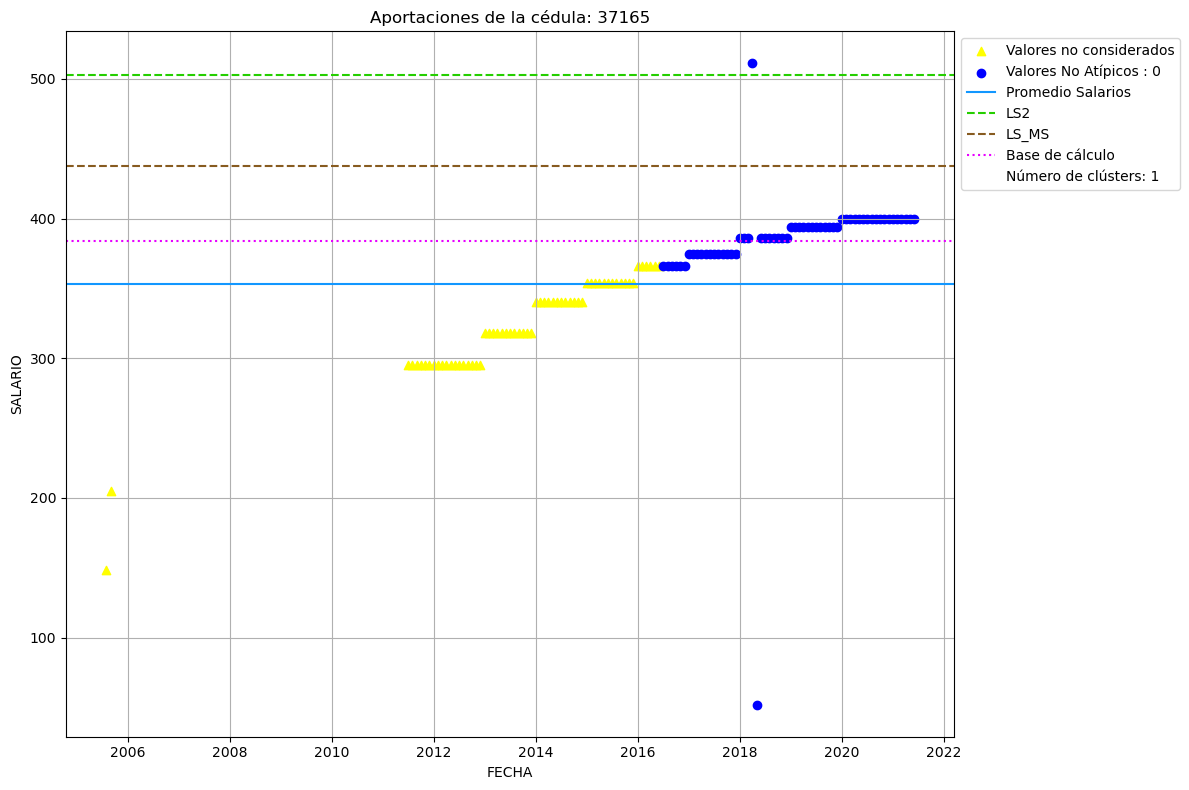

In [53]:
graf_CJ(data_l , 37165, 'SALARIO',  grupo_sel = 0) 

In [61]:
aux = np.array(data_l[ ( data_l['CEDULA_COD']==37165) & (data_l['GRUPO_SEL']==1)]['SALARIO'] ).reshape(-1, 1)
Z = linkage( aux , method='single', metric='euclidean')

num_clusters = 2  # Puedes ajustar este valor según tus necesidades
clusters = fcluster(Z, num_clusters, criterion='maxclust')
print(clusters)
# if( len( np.unique(clusters) ) > 1 ): #Para considerar al menos 2 cluster
#     # Calcular el centroide de cada clúster
cluster_centers = np.array([[ np.nanmean(aux[clusters == i], axis=0)[0], i ] for i in range(1, num_clusters + 1)] ) 
print(cluster_centers)
Q1 = np.quantile(aux, 0.25)
Q3 = np.quantile(aux, 0.75)
IQR = Q3-Q1
LI = Q1 - 1.5 * IQR
LS = Q3 + 1.5 * IQR
print(LS)
cl_at = np.where( cluster_centers[:,0] > (LS +  1e-8) )[0]
print(cl_at)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[389.74864407   1.        ]
 [ 52.03         2.        ]]
437.5
[]


In [64]:
#Analisis para atípicos
del ul, ml
gc.collect()

inicio = time.time()
data = data_l[ data_l['GRUPO_SEL'] == 1 ]
nodata = data_l[ data_l['GRUPO_SEL'] == 0 ]
cedula_1 = data.groupby('CEDULA_COD')['NUM_SEC_MES'].apply( lambda x: (x != 1).any() )
cedula_dist = cedula_1[ cedula_1 ].index
ul = data[ ~data['CEDULA_COD'].isin( cedula_dist )]
ml = data[  data['CEDULA_COD'].isin( cedula_dist )]

fin = time.time()  
tm = fin-inicio
print('\tTiempo de ejecución es:',tm//3600,'horas con',tm%3600//60 ,'minutos y',tm%60,'segundos' )

del data_l
gc.collect()

0

In [68]:
print('Clasificacion para cedulas con único sector', ul['CEDULA_COD'].nunique()) #373069
print('Clasificacion para cedulas con múltiples sectores', ml['CEDULA_COD'].nunique()) #69501

Clasificacion para cedulas con único sector 373069
Clasificacion para cedulas con múltiples sectores 69501


In [69]:
print('Clasificacion para cedulas con único sector', ul['ATI_CJ'].unique()) #[ 0.  1. -1.]
print('Clasificacion para cedulas con múltiples sectores', ml['ATI_CJ'].unique()) # [ 0.  1. -1.]

Clasificacion para cedulas con único sector [ 0.  1. -1.]
Clasificacion para cedulas con múltiples sectores [ 0.  1. -1.]


In [70]:
#Caso a modificarse para cedulas con un unico sector
print('Cedulas con único sector, que fueron clasificados como -1',ul[ (ul['ATI_CJ'] == - 1 )]['CEDULA_COD'].nunique() ) #51259
print('Cedulas con único sector, que fueron clasificados como  1',ul[ (ul['ATI_CJ'] == 1 )]['CEDULA_COD'].nunique() ) #94148
print('Cedulas con único sector, que fueron clasificados como  0',ul[ (ul['ATI_CJ'] == 0 )]['CEDULA_COD'].nunique() ) #316286

Cedulas con único sector, que fueron clasificados como -1 51259
Cedulas con único sector, que fueron clasificados como  1 94148
Cedulas con único sector, que fueron clasificados como  0 316286


In [73]:
#Caso a modificarse
print('Para las çedulas con único sector, que fueron clasificados como -1 y se clasificaran como atipico',
      ul[ (ul['ATI_CJ'] == - 1 ) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique() ) #3943
print('Para las çedulas con único sector, que fueron clasificados como -1 y se clasificaran como no atipico',
      ul[ (ul['ATI_CJ'] == - 1 ) & (ul['SALARIO'] <= ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique() ) # 51247
print('Para las çedulas con único sector, que fueron clasificados como -1 y se clasificaran como no atipico',
      ul[ (ul['ATI_CJ'] == - 1 ) & (ul['SALARIO'] <= ul['SBU'] )]['CEDULA_COD'].nunique() ) # 8007

print('Para las çedulas con único sector, que fueron clasificados como  1 y se clasificaran como no atipico',
      ul[ (ul['ATI_CJ'] == 1 ) & (ul['SALARIO'] <= ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique() ) # 10325
print('Para las çedulas con único sector, que fueron clasificados como  1 y se clasificaran como no atipico',
      ul[ (ul['ATI_CJ'] == 1 ) & (ul['SALARIO'] <= ul['SBU'] )]['CEDULA_COD'].nunique() ) # 8406
print('Para las çedulas con único sector, que fueron clasificados como  0 y se clasificaran como atipico',
      ul[ (ul['ATI_CJ'] == 0 ) & (ul['SALARIO'] > ul['LS2'])]['CEDULA_COD'].nunique() ) #39877

Para las çedulas con único sector, que fueron clasificados como -1 y se clasificaran como atipico 3943
Para las çedulas con único sector, que fueron clasificados como -1 y se clasificaran como no atipico 51247
Para las çedulas con único sector, que fueron clasificados como -1 y se clasificaran como no atipico 8007
Para las çedulas con único sector, que fueron clasificados como  1 y se clasificaran como no atipico 10325
Para las çedulas con único sector, que fueron clasificados como  1 y se clasificaran como no atipico 8406
Para las çedulas con único sector, que fueron clasificados como  0 y se clasificaran como atipico 39877


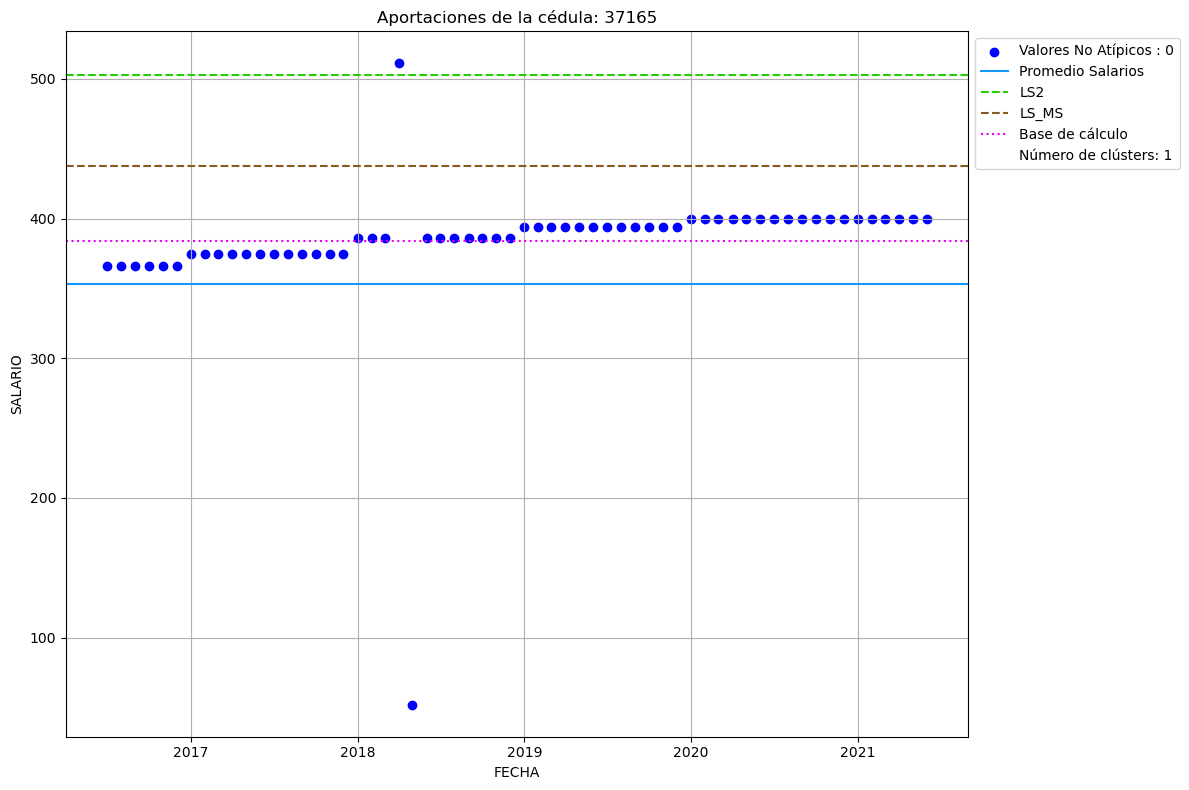

In [75]:
graf_CJ(ul , 37165, 'SALARIO',  grupo_sel = 1) 

In [74]:
ul[ul['CEDULA_COD']==37165]

,CEDULA_COD,ANIO,MES,SALARIO,SALARIO_SECTOR,SECTOR_A,NUM_SEC_MES,%_NUM_SECTOR,GRUPO,SAL_PROM_GRUPO,...,BASE_CAL,SBU,ID_SBU,INDICE,ATI_CJ,LS1,SAL_PROM1,LS2,SAL_PROM2,LS_MS
506450,37165,2016,7,366.00,366.0,PRI,1,1,5,370.5,...,384.12,366.0,0,506450,0.0,503.0,352.87623,503.0,352.87623,437.5
506451,37165,2016,8,366.00,366.0,PRI,1,1,5,370.5,...,384.12,366.0,0,506451,0.0,503.0,352.87623,503.0,352.87623,437.5
506452,37165,2016,9,366.00,366.0,PRI,1,1,5,370.5,...,384.12,366.0,0,506452,0.0,503.0,352.87623,503.0,352.87623,437.5
506453,37165,2016,10,366.00,366.0,PRI,1,1,5,370.5,...,384.12,366.0,0,506453,0.0,503.0,352.87623,503.0,352.87623,437.5
506454,37165,2016,11,366.00,366.0,PRI,1,1,5,370.5,...,384.12,366.0,0,506454,0.0,503.0,352.87623,503.0,352.87623,437.5
506455,37165,2016,12,366.00,366.0,PRI,1,1,5,370.5,...,384.12,366.0,0,506455,0.0,503.0,352.87623,503.0,352.87623,437.5
506456,37165,2017,1,375.00,375.0,PRI,1,1,5,370.5,...,384.12,375.0,0,506456,0.0,503.0,352.87623,503.0,352.87623,437.5
506457,37165,2017,2,375.00,375.0,PRI,1,1,5,370.5,...,384.12,375.0,0,506457,0.0,503.0,352.87623,503.0,352.87623,437.5
506458,37165,2017,3,375.00,375.0,PRI,1,1,5,370.5,...,384.12,375.0,0,506458,0.0,503.0,352.87623,503.0,352.87623,437.5
506459,37165,2017,4,375.00,375.0,PRI,1,1,5,370.5,...,384.12,375.0,0,506459,0.0,503.0,352.87623,503.0,352.87623,437.5


In [76]:
#Correcciones----------------------------------------------------------------------------------------------------------------
#Se hacen las correcciones para los valores -1, en donde si el Salario es mayor a LS1 es atípico( -1 -> 1 )
ul.loc[ (ul['ATI_CJ'] == - 1 ) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_CJ'] = 1 
#Se hacen las correcciones para los valores -1, en donde si el Salario es menor o igual a LS1 no es atípico( -1 -> 0 )
ul.loc[ (ul['ATI_CJ'] == - 1 ) & (ul['SALARIO'] <= ul[['LS2', 'LS_MS']].min(axis=1) ), 'ATI_CJ'] = 0 
#Se hacen las correcciones para los valores -1, en donde si el Salario es menor o igual a un SBU no es atípico( -1 -> 0 )
ul.loc[ (ul['ATI_CJ'] == - 1 ) & (ul['SALARIO'] <= ul['SBU'] ), 'ATI_CJ'] = 0 

#Se hacen las correcciones para los valores 1, en donde si el Salario es menor o igual al min(ls2, ls_ms) no es atípico( 1 -> 0 )
ul.loc[ (ul['ATI_CJ'] == 1 ) & (ul['SALARIO'] <= ul[['LS2', 'LS_MS']].min(axis=1) ), 'ATI_CJ'] = 0
#Se hacen las correcciones para los valores de 1, en donde si el salario es menor al SBU no es atipico (1->0)
ul.loc[ (ul['ATI_CJ'] == 1 ) & (ul['SALARIO'] <= ul['SBU'] ), 'ATI_CJ'] = 0

#Se hacen las correcciones para los valores de 0, en donde si el salario es mayor al LS2  es atipico (0->1)
ul.loc[ (ul['ATI_CJ'] == 0 ) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) ), 'ATI_CJ'] = 1

In [77]:
#Caso a modificarse
print('Cedulas con único sector, que fueron clasificados como -1',ul[ (ul['ATI_CJ'] == - 1 )]['CEDULA_COD'].nunique() )#51259
print('Cedulas con único sector, que fueron clasificados como  1',ul[ (ul['ATI_CJ'] == 1 )]['CEDULA_COD'].nunique() ) #137215
print('Cedulas con único sector, que fueron clasificados como  0',ul[ (ul['ATI_CJ'] == 0 )]['CEDULA_COD'].nunique() ) #373040

Cedulas con único sector, que fueron clasificados como -1 0
Cedulas con único sector, que fueron clasificados como  1 137215
Cedulas con único sector, que fueron clasificados como  0 373040


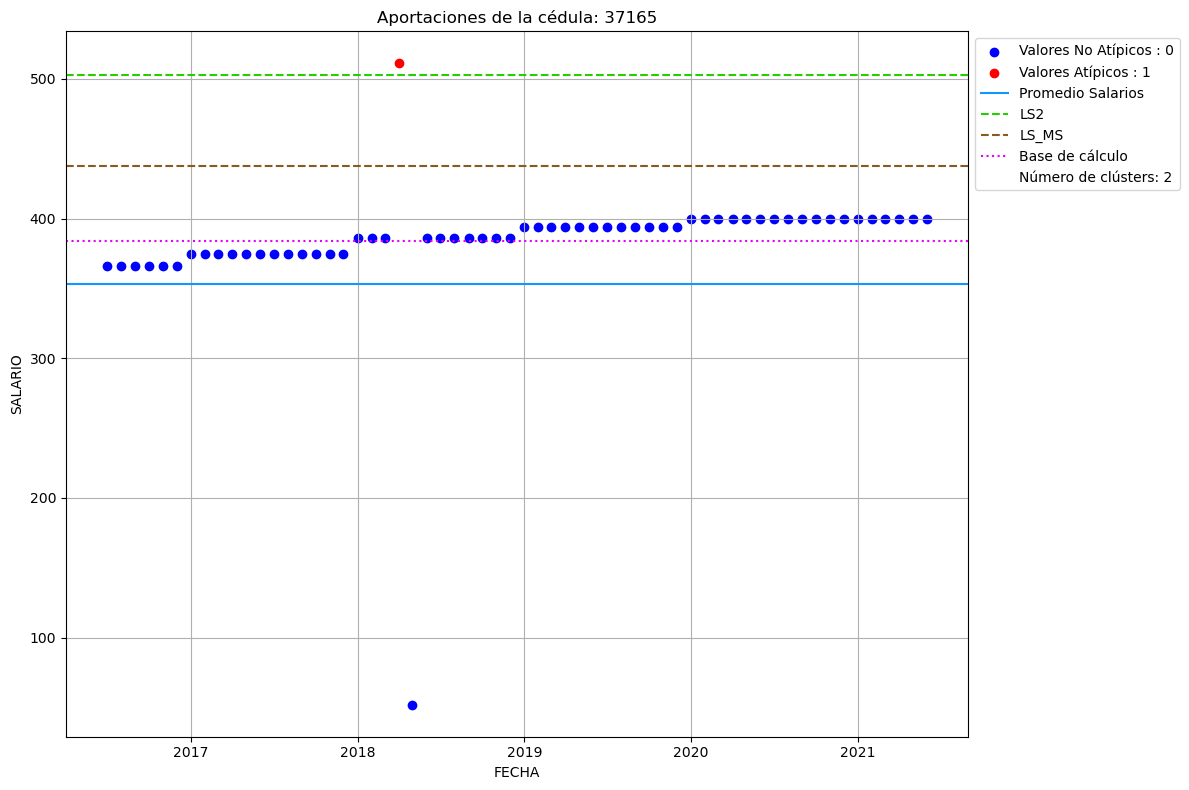

In [78]:
graf_CJ(ul , 37165, 'SALARIO',  grupo_sel = 1) 

In [79]:
#Caso a modificarse
print('Cedulas con múltiples sectores, que fueron clasificados como -1',
        ml[ (ml['ATI_CJ'] == - 1 )]['CEDULA_COD'].nunique() ) #862
print('Cedulas con múltiples sectores, que fueron clasificados como  1',
        ml[ (ml['ATI_CJ'] == 1 )]['CEDULA_COD'].nunique() ) #29702
print('Cedulas con  múltiples sectores, que fueron clasificados como 0',
        ml[ (ml['ATI_CJ'] == 0 )]['CEDULA_COD'].nunique() ) #67396

Cedulas con múltiples sectores, que fueron clasificados como -1 862
Cedulas con múltiples sectores, que fueron clasificados como  1 29702
Cedulas con  múltiples sectores, que fueron clasificados como 0 67396


In [83]:
ml[(ml['ATI_CJ'] == - 1 ) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].unique()

array([   12738,    27006,    32481,    59004,   115437,   135357,
         135752,   139845,   140711,   153129,   154409,   154424,
         155809,   163969,   164678,   166124,   171598,   171876,
         174592,   174876,   183766,   221502,   228832,   944115,
        1033967,  1123789,  1149995,  1166694,  1191707,  1387930,
        1493588,  1652922,  1663507,  1684421,  1752616,  1830415,
        1851236,  1884930,  1886110,  1896625,  1901469,  1911098,
        1953640,  1985570,  2070633,  2097705,  2119745,  2183936,
        2184722,  2189229,  2189657,  2192076,  2206267,  2670916,
        2696188,  2760874,  2761641,  2764106,  2768630,  2772717,
        2776829,  2785309,  2802001,  2821800,  2829316,  2829582,
        2830718,  2834298,  2840622,  2845603,  2859969,  2869340,
        2904439,  2911811,  2919650,  3378174,  3382787,  3388403,
        3453377,  3464101,  3502512,  3510405,  3523741,  3537980,
        3545920,  3549373,  3564203,  3574015,  3595280,  3595

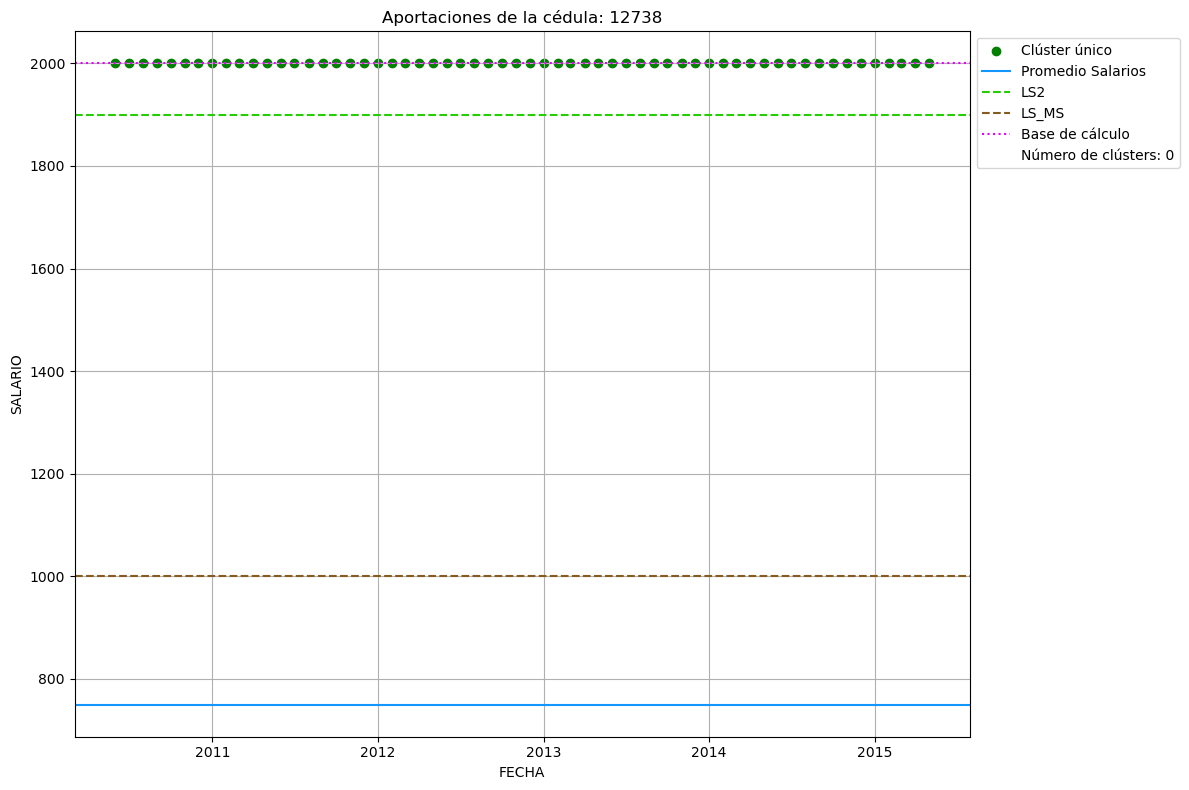

In [87]:
graf_CJ(ml ,  12738, 'SALARIO',  grupo_sel = 1) 

In [88]:
ml[ml['CEDULA_COD']==12738]

,CEDULA_COD,ANIO,MES,SALARIO,SALARIO_SECTOR,SECTOR_A,NUM_SEC_MES,%_NUM_SECTOR,GRUPO,SAL_PROM_GRUPO,...,BASE_CAL,SBU,ID_SBU,INDICE,ATI_CJ,LS1,SAL_PROM1,LS2,SAL_PROM2,LS_MS
116250,12738,2010,6,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,2000.0,240.0,-1,116250,-1.0,1900.0,749.825081,1900.0,749.825081,1000.0
116251,12738,2010,7,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,2000.0,240.0,-1,116251,-1.0,1900.0,749.825081,1900.0,749.825081,1000.0
116252,12738,2010,8,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,2000.0,240.0,-1,116252,-1.0,1900.0,749.825081,1900.0,749.825081,1000.0
116253,12738,2010,9,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,2000.0,240.0,-1,116253,-1.0,1900.0,749.825081,1900.0,749.825081,1000.0
116254,12738,2010,10,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,2000.0,240.0,-1,116254,-1.0,1900.0,749.825081,1900.0,749.825081,1000.0
116255,12738,2010,11,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,2000.0,240.0,-1,116255,-1.0,1900.0,749.825081,1900.0,749.825081,1000.0
116256,12738,2010,12,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,2000.0,240.0,-1,116256,-1.0,1900.0,749.825081,1900.0,749.825081,1000.0
116257,12738,2011,1,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,2000.0,264.0,-1,116257,-1.0,1900.0,749.825081,1900.0,749.825081,1000.0
116258,12738,2011,2,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,2000.0,264.0,-1,116258,-1.0,1900.0,749.825081,1900.0,749.825081,1000.0
116259,12738,2011,3,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,2000.0,264.0,-1,116259,-1.0,1900.0,749.825081,1900.0,749.825081,1000.0


In [89]:
dic_sim = ml.groupby('CEDULA_COD').agg({'SALARIO_SECTOR': list, 'LS2':list,'LS_MS':list,'INDICE': list}).to_dict(orient='index')

for cedula in dic_sim:
    dic_sim[cedula]['SALARIO_SECTOR'] = [[float(val) for val in sal.split(';')] if isinstance(sal, str) else [sal] 
                                          for sal in dic_sim[cedula]['SALARIO_SECTOR']]

    min_ls = [min(ls2, ls_as) for ls2, ls_as in zip(dic_sim[cedula]['LS2'], dic_sim[cedula]['LS_MS'])]

    dic_sim[cedula]['ATI_CJ_AS'] = [ 1 if any(sal > ls for sal in salarios) else 0 
                                    for salarios, ls in zip( dic_sim[cedula]['SALARIO_SECTOR'], min_ls )]

data1 = { 'CEDULA_COD': [], 'SALARIO_SECTOR': [], 
          'LS_MS' : [], 'ATI_CJ_AS':[],  'INDICE':[]}

# Llenar las listas con los datos del diccionario
for cedula, values in dic_sim.items():
    salario = values['SALARIO_SECTOR']
    ls = values[ 'LS_MS' ]
    atipico = values[ 'ATI_CJ_AS' ]
    indice = values['INDICE']
    num_rows = len(salario)

    # Extender las listas en el diccionario de datos
    data1['CEDULA_COD'].extend([cedula] * num_rows)
    data1['SALARIO_SECTOR'].extend(salario)
    data1['LS_MS' ].extend(ls)
    data1['ATI_CJ_AS' ].extend(atipico)
    data1['INDICE'].extend(indice)

data1 = pd.DataFrame( data1 )
data1.set_index('INDICE', inplace=True )
cedul = list(dic_sim.keys())  #total de 111903
filtro = data1[ data1['CEDULA_COD'].isin(cedul )] # 111903 cedulas
indi = filtro.index
ml.loc[ indi, 'ATI_CJ_AS'] = filtro['ATI_CJ_AS']

del data1,  dic_sim, cedul, filtro, indi, salario, ls, atipico, indice, num_rows
gc.collect()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_16304\2200233366.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml.loc[ indi, 'ATI_CJ_AS'] = filtro['ATI_CJ_AS']


0

In [91]:
#Caso a modificarse para cedulas que tiene múltiples sectores
print('Para las çedulas con único sector, que fueron clasificados como -1 y se clasificaran como atipico',
      ml[ (ml['ATI_CJ'] == - 1 ) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique() ) # 468
print('Para las çedulas con único sector, que fueron clasificados como -1 y se clasificaran como no atipico',
      ml[ (ml['ATI_CJ'] == - 1 ) & (ml['SALARIO'] <= ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique() ) # 758
print('Para las çedulas con único sector, que fueron clasificados como -1 y se clasificaran como no atipico',
      ml[ (ml['ATI_CJ'] == - 1 ) & (ml['SALARIO'] <= ml['SBU'] )]['CEDULA_COD'].nunique() ) # 191

print('Para las çedulas con único sector, que fueron clasificados como  1 y se clasificaran como no atipico',
      ml[ (ml['ATI_CJ'] == 1 ) & (ml['ATI_CJ_AS'] == 0)]['CEDULA_COD'].nunique() ) #16724
print('Para las çedulas con único sector, que fueron clasificados como  1 y se clasificaran como atipico',
      ml[ (ml['ATI_CJ'] == 0 ) & (ml['ATI_CJ_AS'] == 1)]['CEDULA_COD'].nunique() ) # 24790


Para las çedulas con único sector, que fueron clasificados como -1 y se clasificaran como atipico 468
Para las çedulas con único sector, que fueron clasificados como -1 y se clasificaran como no atipico 758
Para las çedulas con único sector, que fueron clasificados como -1 y se clasificaran como no atipico 191
Para las çedulas con único sector, que fueron clasificados como  1 y se clasificaran como no atipico 16724
Para las çedulas con único sector, que fueron clasificados como  1 y se clasificaran como atipico 24790


In [92]:
#Se hacen las correcciones para los valores -1, en donde si el Salario es mayor a LS1 es atípico( -1 -> 1 )
ml.loc[ (ml['ATI_CJ'] == - 1 ) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) ), 'ATI_CJ'] = 1 
#Se hacen las correcciones para los valores -1, en donde si el Salario es menor o igual a LS1 no es atípico( -1 -> 0 )
ml.loc[ (ml['ATI_CJ'] == - 1 ) & (ml['SALARIO'] <= ml[['LS2', 'LS_MS']].min(axis=1) ), 'ATI_CJ'] = 0 
#Se hacen las correcciones para los valores -1, en donde si el Salario es menor o igual a un SBU no es atípico( -1 -> 0 )
ml.loc[ (ml['ATI_CJ'] == - 1 ) & (ml['SALARIO'] <= ml['SBU'] ), 'ATI_CJ'] = 0 

#Se hacen las correcciones para los valores 1, en donde si el Salario es menor o igual al min(ls2, ls_ms) no es atípico( 1 -> 0 )
ml.loc[  (ml['ATI_CJ'] == 1 ) & (ml['ATI_CJ_AS'] == 0), 'ATI_CJ'] = ml['ATI_CJ_AS']
#Se hacen las correcciones para los valores de 1, en donde si el salario es menor al SBU no es atipico (1->0)
ml.loc[ (ml['ATI_CJ'] == 0 ) & (ml['ATI_CJ_AS'] == 1), 'ATI_CJ'] = ml['ATI_CJ_AS']


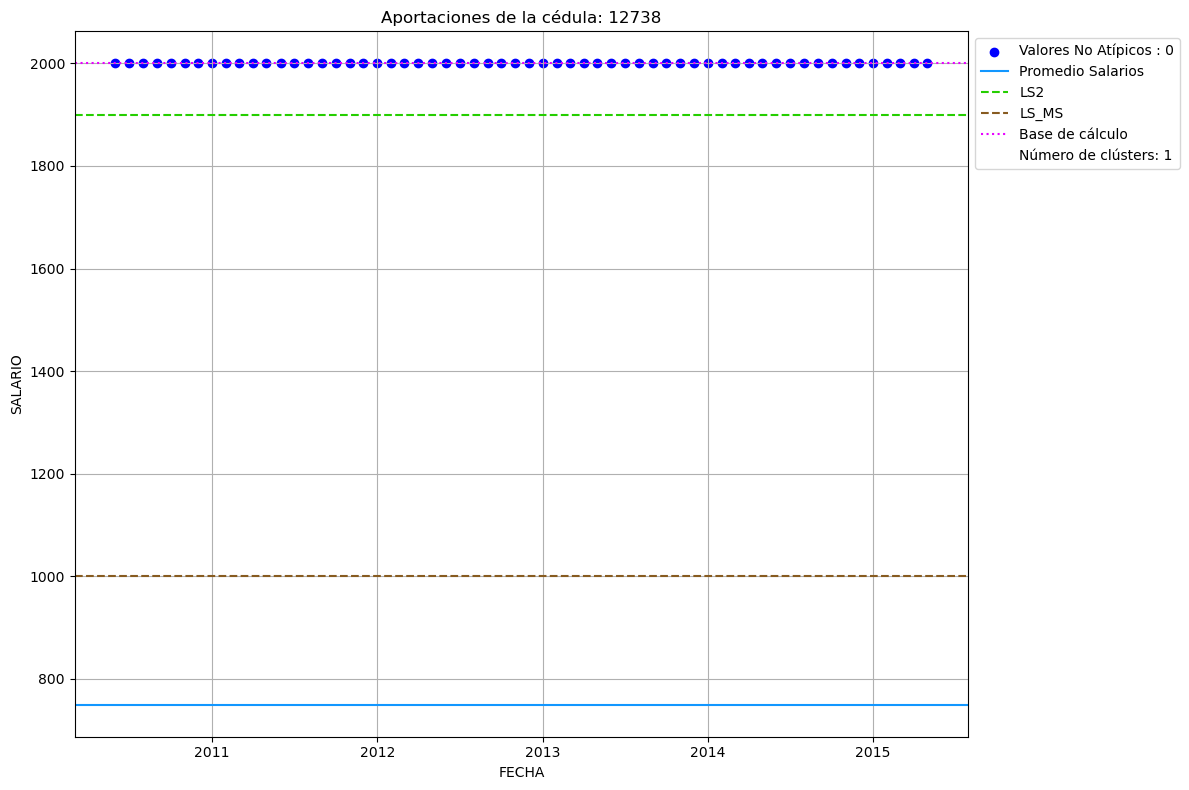

In [93]:
graf_CJ(ml ,  12738, 'SALARIO',  grupo_sel = 1) 

In [94]:
ml[ml['CEDULA_COD']==12738]

,CEDULA_COD,ANIO,MES,SALARIO,SALARIO_SECTOR,SECTOR_A,NUM_SEC_MES,%_NUM_SECTOR,GRUPO,SAL_PROM_GRUPO,...,SBU,ID_SBU,INDICE,ATI_CJ,LS1,SAL_PROM1,LS2,SAL_PROM2,LS_MS,ATI_CJ_AS
116250,12738,2010,6,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,240.0,-1,116250,0.0,1900.0,749.825081,1900.0,749.825081,1000.0,0
116251,12738,2010,7,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,240.0,-1,116251,0.0,1900.0,749.825081,1900.0,749.825081,1000.0,0
116252,12738,2010,8,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,240.0,-1,116252,0.0,1900.0,749.825081,1900.0,749.825081,1000.0,0
116253,12738,2010,9,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,240.0,-1,116253,0.0,1900.0,749.825081,1900.0,749.825081,1000.0,0
116254,12738,2010,10,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,240.0,-1,116254,0.0,1900.0,749.825081,1900.0,749.825081,1000.0,0
116255,12738,2010,11,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,240.0,-1,116255,0.0,1900.0,749.825081,1900.0,749.825081,1000.0,0
116256,12738,2010,12,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,240.0,-1,116256,0.0,1900.0,749.825081,1900.0,749.825081,1000.0,0
116257,12738,2011,1,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,264.0,-1,116257,0.0,1900.0,749.825081,1900.0,749.825081,1000.0,0
116258,12738,2011,2,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,264.0,-1,116258,0.0,1900.0,749.825081,1900.0,749.825081,1000.0,0
116259,12738,2011,3,2000.0,1000.0;1000.0,PRI;PRI,2,0.5;0.5,12,2000.0,...,264.0,-1,116259,0.0,1900.0,749.825081,1900.0,749.825081,1000.0,0


In [95]:
#Caso a modificarse
print('Cedulas con múltiples sectores, que fueron clasificados como -1',
        ml[ (ml['ATI_CJ'] == - 1 )]['CEDULA_COD'].nunique() ) #862
print('Cedulas con múltiples sectores, que fueron clasificados como  1',
        ml[ (ml['ATI_CJ'] == 1 )]['CEDULA_COD'].nunique() ) #33943
print('Cedulas con  múltiples sectores, que fueron clasificados como 0',
        ml[ (ml['ATI_CJ'] == 0 )]['CEDULA_COD'].nunique() ) #69324

Cedulas con múltiples sectores, que fueron clasificados como -1 0
Cedulas con múltiples sectores, que fueron clasificados como  1 33943
Cedulas con  múltiples sectores, que fueron clasificados como 0 69324


In [ ]:
nodata.columns

In [ ]:
ul.columns

In [ ]:
ml.columns

In [96]:
print('Concatenación de dataframe')
inicio = time.time()
val = ['CEDULA_COD', 'ANIO', 'MES', 'SALARIO', 'SALARIO_SECTOR', 'SECTOR_A',
       'NUM_SEC_MES', '%_NUM_SECTOR', 'GRUPO', 'SAL_PROM_GRUPO', 'GRUPO_SEL',
       'INI_CAL', 'FIN_CAL', 'BASE_CAL', 'SBU', 'ID_SBU', 'INDICE', 'ATI_CJ',
       'LS1', 'SAL_PROM1', 'LS2', 'SAL_PROM2', 'LS_MS']

data_jerar = None
data_jerar = pd.concat( [ nodata[val] ,
                          ul[val], ml[val] ], axis=0)

data_jerar = data_jerar.sort_values( by=["INDICE"], ascending=[ True ] )
data_jerar.reset_index(inplace=True)
data_jerar.rename(columns={'index': 'nuevo_indice'}, inplace=True)
data_jerar.drop(columns=['nuevo_indice'], inplace=True)

fin = time.time()  
tm = fin-inicio
print('\tTiempo de ejecución es:',tm//3600,'horas con',tm%3600//60,'minutos y',tm%60,'segundos' )

Concatenación de dataframe
	Tiempo de ejecución es:  0.0  horas con  5.0  minutos y 3.362321376800537  segundos


In [97]:
# Guadar archivo------------------------------------------------------------------------------------------------------------
nombre_archivo = 'viu_cj_data_ati.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto8 = data_jerar

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto8, archivo)      

del objeto8

In [ ]:
data_jerar

In [ ]:
grouped = data_jerar['CEDULA_COD'].drop_duplicates().sample(n=30000, random_state=1)
muestra = data_jerar[data_jerar['CEDULA_COD'].isin(grouped)]
muestra.to_csv('muestra_cj.txt', sep='\t', index=False)# Agrupar por CEDULA_COD

In [ ]:
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_clean_data_l.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open( ruta_archivo, 'rb') as archivo:
    data_l = pickle.load( archivo ) 

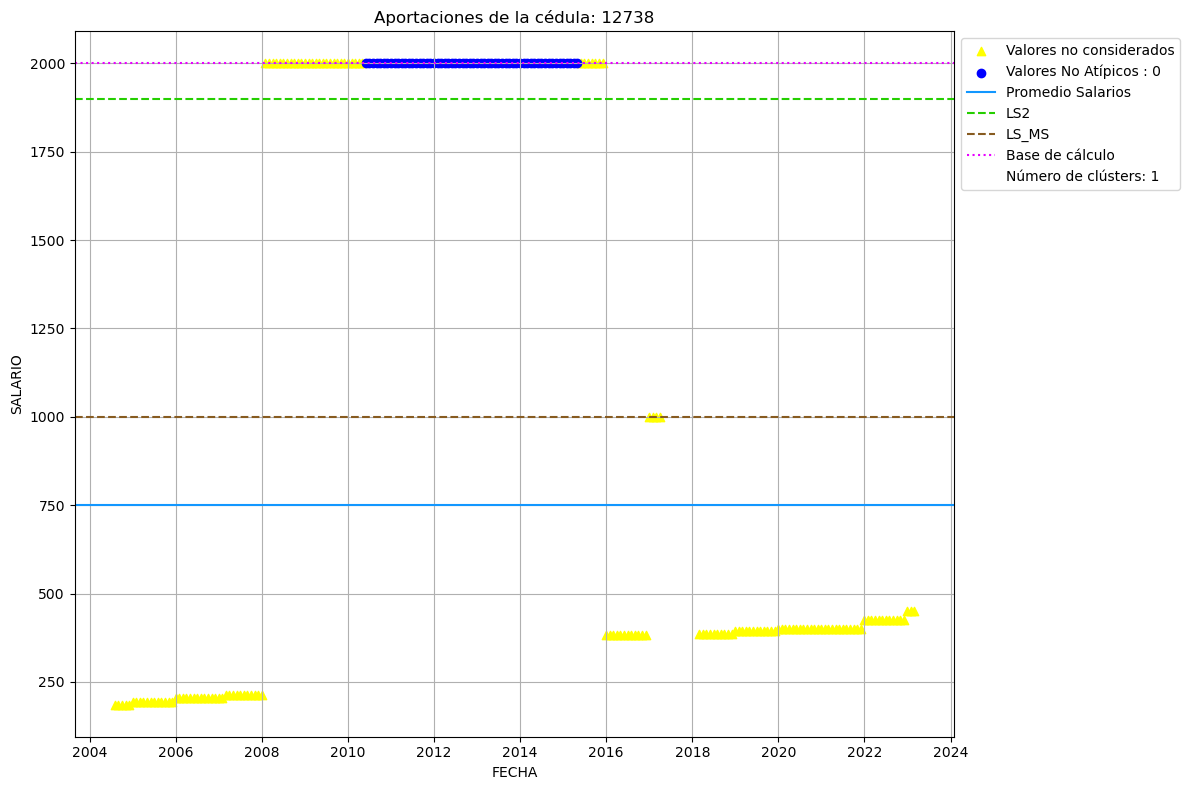

In [98]:
graf_CJ(data_jerar ,  12738, 'SALARIO',  grupo_sel = 0) 

In [104]:
#Verificación de valores LS calculados
a = [ [float(val) for val in sal.replace(':', ';').split(';')] 
                                        if isinstance(sal, str) 
                                        else [float(sal)]
                                        for sal in data_jerar[ (data_jerar['CEDULA_COD']==12738) & (data_jerar['ANIO']>=2000)]['SALARIO_SECTOR']
                                    ]
# Aplanar la lista de listas de SALARIO_SECTOR
salarios = None
salarios = [salario for sublist in a for salario in sublist]
salarios
print('sal promedio', np.nanmean(salarios))
q1=  np.percentile(salarios, 25)
q3 =  np.percentile(salarios, 75)
iqr = q3 -  q1
print('Ls', q3+1.5*iqr)

sal promedio 749.8250809061489
Ls 1900.0


In [103]:
data_jerar[ (data_jerar['CEDULA_COD']==12738)]['SALARIO_SECTOR']

116180    185.77
116181    185.77
116182    185.77
116183    185.77
116184    185.77
           ...  
116389     425.0
116390     425.0
116391     450.0
116392     450.0
116393     450.0
Name: SALARIO_SECTOR, Length: 214, dtype: object